# CTR Prediction using Factorization Machines at Scale
## MIDS w261 Final Project
## December 12, 2018

**Authors**: Colby Carter, Kalvin Kao, Adam Letcher, Jennifer Philippou

Link to working doc (temp):
https://docs.google.com/document/d/1BPxVEwYjh5-z-ZjXoMQVcgFdRSDTYC6WTdbH3Dky0hA/edit

## 1. Project Purpose    

Goal  

Questions  

Purpose  

Performance required  

http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/

https://www.kaggle.com/c/criteo-display-ad-challenge


## 2. Factorization Machines    

(explanation)  

https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf


![FM Equation](FINAL/images/FM_equation_Rendle2010.png)

From which the right-hand summands can re-written as the following average of differences between dot products for each factor `k`:

![FM factor](FINAL/images/FM_factor_Rendle2010.png)

### Toy Example

In [1]:
import numpy as np

%reload_ext autoreload
%autoreload 2

In [36]:
toyDataRaw = ['1\t0\t5\t\t1\t26\tcat\tblue\t\tpizza',
            '0\t1\t10\t1\t\t12\tdog\tyellow\t\t',
            '0\t0\t\t0.5\t2\t45\tdog\t\tcar\tsteak']

In [22]:
# parse out label and features
toyDataParsed = []
for row in toyDataRaw:
    splitRow = row.split('\t')
    toyDataParsed.append((splitRow[0], splitRow[1:]))
    
print("Toy data made up of label followed by numeric and categorical features:")
toyDataParsed

Toy data made up of label followed by numeric and categorical features:


[('1', ['0', '5', '', '1', '26', 'cat', 'blue', '', 'pizza']),
 ('0', ['1', '10', '1', '', '12', 'dog', 'yellow', '', '']),
 ('0', ['0', '', '0.5', '2', '45', 'dog', '', 'car', 'steak'])]

### Summarize Data

In [3]:
ncol = len(toyDataParsed[0][1])
nrow = len(toyDataParsed)
print(f'This toy exmaple  contains {nrow} rows and {ncol} columns, plus a label in index 0.')

This toy exmaple  contains 3 rows and 9 columns, plus a label in index 0.


In [4]:
def avgFeatures(row):
    count = 0
    feats = row[1][:]
    for feat in feats:
        if feat != '':
            count += 1
    return count

nonSparse = [avgFeatures(row) for row in toyDataParsed]

print("There is an average of", str(round(np.mean(nonSparse),2)), "populated features per observation.")

There is an average of 6.67 populated features per observation.


### One-Hot Encode Features

In [5]:
# binarize
def makeString(data):
    """Get list of features and make them into distinct strings according to column index"""
     #include label for SGD
    newData = []
    for r, row in enumerate(data):
        label = row[0]
        id_feats = []
        for i, value in enumerate(row[1], 1):
            if value=='':
                add='NA'
            else:
                add=value
            id_feats.append("v"+str(i)+"="+add)
        newData.append((label, id_feats))
    
    return newData
    
stringData = makeString(toyDataParsed)
print("Example of string-indexed features:")
stringData[0]

Example of string-indexed features:


('1',
 ['v1=0',
  'v2=5',
  'v3=NA',
  'v4=1',
  'v5=26',
  'v6=cat',
  'v7=blue',
  'v8=NA',
  'v9=pizza'])

In [6]:
def oneHotEncode(data):
    """turn indexed-string features into one-hot encoded features"""

    setFeats = set()
    for row in data:
        setFeats.update(row[1])
    listFeats = list(setFeats)
    print("Features:")
    print(listFeats)
    newData = np.zeros(shape=(len(data), len(listFeats)+1))

    for r, row in enumerate(data):
        newData[r][0] = row[0]    #first index is the label
        for var in row[1]:
            newData[r][listFeats.index(var)+1] = 1
            
    return newData, len(listFeats)
    
oneHotData, numFeats = oneHotEncode(stringData)
print("\nOne-hot encoded featres (first element is label):")
oneHotData[0]

Features:
['v8=NA', 'v7=NA', 'v1=0', 'v9=steak', 'v3=NA', 'v4=1', 'v4=2', 'v7=blue', 'v5=12', 'v9=NA', 'v2=5', 'v2=NA', 'v4=NA', 'v3=0.5', 'v5=45', 'v8=car', 'v5=26', 'v6=dog', 'v1=1', 'v6=cat', 'v2=10', 'v7=yellow', 'v3=1', 'v9=pizza']

One-hot encoded featres (first element is label):


array([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1.])

### Model Updates using Stochastic Gradient Descent

In [7]:
# initialize model
b = 0.0
w_vector = np.random.normal(0.0, 0.02, (1, numFeats))
k = 2    #number of latent factors
V_matrix = np.random.normal(0.0, 0.02, (k, numFeats))   #k factors

print("Initialized weight vector W:")
w_vector

Initialized weight vector W:


array([[-0.03328396,  0.03109567, -0.00353963,  0.00108691,  0.01301888,
         0.00522236,  0.01511192, -0.00106579, -0.00058697,  0.00502548,
         0.00981188, -0.00124704,  0.00902628, -0.00041259, -0.00939172,
        -0.01471153,  0.02622656, -0.00783223, -0.00401789,  0.00080727,
         0.03522305, -0.02387439, -0.00679598, -0.00943945]])

Using logarithmic-loss as our cost function along with the chain rule, we can use the product of the following partial derivatives with loss function's derivative, $(\hat{p_i} - y_i)$, to estimate gradients by parameter:

![FM factor](FINAL/images/FM_partials_Rendle2010.png)

In [2]:
def estimateGradientToy(record, k, b, w, V):
    """
        Compute the predicted probability AND return the gradients
        Args:
            record - label followed by binarized feature values
        Model:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            pair - ([label, predicted probability], [set of weight vectors in csr_matrix format])
    """
    
    label = record[0]
    feats = record[1:]
    
    # calculate P-hat    
    # start with linear weight dot product (X dot W)
    linear_sum = np.dot(w, feats)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k
    rh_factor = [0.0]*k
    for f in range(0, k):
        lh_factor[f] = np.dot(V[f][:], feats)  #KEY--this is used in v_grad matrix below
        rh_factor[f] = np.dot(V[f][:]**2, feats**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    y_hat = b + linear_sum + factor_sum
    
    p_hat = 1.0 / (1 + float(np.exp(-y_hat)))  #logit transformation
    
    #compute Gradients
    b_grad = p_hat - label    #the partial derivative of log-loss function wrt constant beta
    
    w_grad = b_grad*feats
    
    v_data = np.array([])
    for f in range(0, k):
        v_data = np.append(v_data, b_grad*(lh_factor[f]*feats - np.multiply(V[f][:], feats**2)))
    v_grad = np.reshape(v_data, newshape=(k, V.shape[1]))
    
    return ([label, p_hat], [b_grad, w_grad, v_grad])

In [26]:
# for one example
gradient = estimateGradientToy(oneHotData[0], k, b, w_vector, V_matrix)
print("(Label, predicted probability), [beta, w vector, V matrix]:")
gradient

(Label, predicted probability), [beta, w vector, V matrix]:


([1.0, 0.5024168636288922],
 [-0.49758313637110785,
  array([-0.49758314, -0.        , -0.49758314, -0.        , -0.49758314,
         -0.49758314, -0.        , -0.49758314, -0.        , -0.        ,
         -0.49758314, -0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.49758314, -0.        , -0.        , -0.49758314,
         -0.        , -0.        , -0.        , -0.49758314]),
  array([[-0.051016  , -0.        , -0.03645439, -0.        , -0.03854385,
          -0.02986771, -0.        , -0.03737504, -0.        , -0.        ,
          -0.02509388, -0.        , -0.        , -0.        , -0.        ,
          -0.        , -0.05390807, -0.        , -0.        , -0.01865564,
          -0.        , -0.        , -0.        , -0.04345672],
         [ 0.0244058 , -0.        ,  0.02071585, -0.        ,  0.02966948,
           0.03270131,  0.        ,  0.01629193,  0.        , -0.        ,
           0.03281537, -0.        , -0.        , -0.        , -0.        ,
 

In [10]:
def logLossToy(pair):
    """parallelize log loss
        input: ([label, prob], [b_grad, w_grad, v_grad])
    """
    y = pair[0][1]
    
    eps = 1.0e-16
    if pair[0][1] == 0:
        p_hat = eps
    elif pair[0][1] == 1:
        p_hat = 1-eps
    else:
        p_hat = pair[0][1]
    
    return float(-(y * np.log(p_hat) + (1-y) * np.log(1-p_hat)))

In [11]:
logLossToy(gradient)

0.6931354980548503

In [24]:
# update weights
learningRate = 0.1

wGrad_reduce = np.zeros((1, numFeats))
for r in range(0, nrow):
    gradient = estimateGradientToy(oneHotData[r], k, b, w_vector, V_matrix)
    wGrad_reduce += gradient[1][1]
w_update = wGrad_reduce / nrow

w_new = w_vector - learningRate*w_update

print("New weight vector W")
w_new.T

New weight vector W


array([[-0.03310685],
       [ 0.01428775],
       [-0.00376144],
       [-0.015721  ],
       [ 0.02960499],
       [ 0.02180846],
       [-0.001696  ],
       [ 0.01552031],
       [-0.01699597],
       [-0.01138352],
       [ 0.02639799],
       [-0.01805496],
       [-0.00738271],
       [-0.01722051],
       [-0.02619963],
       [-0.03151945],
       [ 0.04281266],
       [-0.04104915],
       [-0.02042689],
       [ 0.01739337],
       [ 0.01881405],
       [-0.04028339],
       [-0.02320497],
       [ 0.00714665]])

In [23]:
# update V matrix

vGrad_reduce = np.zeros((k, numFeats))
for r in range(0, nrow):
    gradient = estimateGradientToy(oneHotData[r], k, b, w_vector, V_matrix)
    vGrad_reduce += gradient[1][2]
v_update = vGrad_reduce / nrow

V_new = V_matrix - learningRate*v_update

print("New factor matrix V weights:")
V_new.T

New factor matrix V weights:


array([[-0.01659269, -0.0107129 ],
       [-0.00526753, -0.01770845],
       [ 0.01061032, -0.01639128],
       [ 0.03818184, -0.00625369],
       [ 0.00782152, -0.00024604],
       [ 0.02496888,  0.00574602],
       [ 0.01363172,  0.01560516],
       [ 0.01013153, -0.02668518],
       [ 0.01761522,  0.00018196],
       [-0.06089243, -0.03704973],
       [ 0.03440378,  0.00597145],
       [ 0.01331686, -0.01696164],
       [ 0.02983592, -0.01582817],
       [ 0.02259963, -0.04301197],
       [ 0.00912995, -0.01519263],
       [-0.00842256, -0.00671412],
       [-0.02254404, -0.00990762],
       [-0.01389515,  0.01140745],
       [-0.00252248,  0.00297071],
       [ 0.04712819, -0.01923517],
       [-0.01277656,  0.01345092],
       [ 0.0081833 ,  0.02907576],
       [ 0.02244913,  0.00251953],
       [-0.00188818,  0.00624993]])

## 3. Exploration of Criteo Training Dataset  

*Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable*

In [29]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from scipy.sparse import csr_matrix
from pyspark.sql import Row
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import DataFrame

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261FinalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`NOTE:`__ Monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

#### Load Training Data Sample for Local Testing

In [7]:
original_trainRDD = sc.textFile('data/train.txt')

splits = 0.0001

largeRDD, smallTestRDD, smallTrainRDD = original_trainRDD.randomSplit([1-2*splits, splits, splits], seed = 1)
smallTrainRDD.cache()

ncol = len(smallTrainRDD.take(1)[0].split('\t'))
nrow = smallTrainRDD.count()
print(f'This sample contains {nrow} rows and {ncol} columns')

This sample contains 4478 rows and 40 columns


### Numeric Variables

In [27]:
# distributions/transformation?/bucketing
# correlations
# missings

### Categorical Variables

In [28]:
# frequency distributions
# missings

### Binarization, Dimensionality and Sparsity

In [8]:
def avgFeatures(line):
    count = 0
    feats = line.split('\t')[1:]
    for feat in feats:
        if feat != '':
            count += 1
    return count

print("There is an average of", str(round(smallTrainRDD.map(avgFeatures).mean(),2)), "populated features per observation.")

There is an average of 33.53 populated features per observation.


## 4. FM Implementation

### Pre-Processing

In [9]:
# function to parse raw data and tag feature values with type and feature indices
def parseCV(line):
    """
    Map text records to --> (label, features)
    Bucket (string) numeric features
    Add variable index prefix to feature values for binarization
    """

    # start of categorical features
    col_start = 14
    
    raw_values = line.split('\t')
    label = int(raw_values[0])
    
    # parse numeric features
    numericals = []
    for idx, value in enumerate(raw_values[1:col_start]):
        if value == '':
            append_val = 'NA'
        elif value == '0':
            append_val = '0'
        else:
            # continues variables
            if idx in [0,3,6,7]:
                if float(value)<10:
                    append_val = '<10'
                elif float(value)<25:
                    append_val = '<25'
                else:
                    append_val = '>25'
            elif idx in [1,2,5]:
                if float(value)<100:
                    append_val = '<100'
                else:
                    append_val = '>100'
            elif idx==4:
                if float(value)<10000:
                    append_val = '<10k'
                elif float(value)<50000:
                    append_val = '<50k'
                else:
                    append_val = '>50k'
            elif idx==8:
                if float(value)<100:
                    append_val = '<100'
                elif float(value)<500:
                    append_val = '<500'
                else:
                    append_val = '>500'
            elif idx in [10,11]:
                if float(value)<3:
                    append_val = '<3'
                elif float(value)<6:
                    append_val = '<6'
                else:
                    append_val = '>6'
            elif idx==12:
                if float(value)<5:
                    append_val = '<5'
                elif float(value)<10:
                    append_val = '<10'
                elif float(value)<25:
                    append_val = '<25'
                else:
                    append_val = '>25'
            # ordinal/binary cases
            else:
                append_val = str(value)
                
        numericals.append('n' + str(idx) + '_' + append_val)
            
    # parse categorical features
    categories = []
    for idx, value in enumerate(raw_values[col_start:]):
        if value == '':
            categories.append('c'+ str(idx) + '_NA')
        else:
            categories.append('c'+ str(idx) + '_' + str(value))

    return Row(label=label, raw=numericals + categories)

In [10]:
# call functions
parsedDF = smallTrainRDD.map(parseCV).toDF()

### One-Hot Encode All Features using CountVectorizer for Sparse Representation

In [11]:
# function to one hot encode all features using a count vectorizer
def vectorizeCV(DF):
    
    vectorizer = CountVectorizer()
    cv = CountVectorizer(minDF=1, inputCol="raw", outputCol="features")
    
    model = cv.fit(DF)
    result = model.transform(DF)
    
    return result, model

In [12]:
vectorizedDF, cvModel = vectorizeCV(parsedDF)
vectorizedDF.show(truncate=True)

+-----+--------------------+--------------------+
|label|                 raw|            features|
+-----+--------------------+--------------------+
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,5...|
|    1|[n0_NA, n1_<100, ...|(25739,[0,2,3,4,5...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,4,5,6...|
|    1|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    1|[n0_NA, n1_<100, ...|(25739,[1,2,3,5,6...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,5,6...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,5...|
|    0|[n0_0, n1_>100, n...|(25739,[0,1,3,4,7...|
|    0|[n0_NA, n1_0, n2_...|(25739,[0,2,3,4,8...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,4,5...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,4,5...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,7...|
|    0|[n0_0, n1_>100, n...|(25739,[0,1,4,6,8...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,5,6...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,7...|
|    0|[n0_NA, n1_>100, ...|(25739,[0,1,2,3,7...|


In [13]:
vectorizedRDD = vectorizedDF.select(['label', 'features']).rdd.cache()

In [15]:
num_feats = vectorizedRDD.take(1)[0][1].size
percent_pos = vectorizedRDD.map(lambda x: x[0]).mean()

print("Number of total expanded features:", num_feats)
print("Relative frequency of positive class:", percent_pos)

Number of total expanded features: 25739
Relative frequency of positive class: 0.25949084412684253


## Prediction and SGD

In [17]:
def predictGrad(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability for average loss AND return the gradients
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of ([label, predicted probability], [set of weight vectors in csr_matrix format])
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)  #KEY--this is used in v_grad matrix below
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    #compute Gradients
    b_grad = prob - label
    
    w_grad = csr_matrix((b_grad*feats.values, (np.zeros(feats.indices.size), feats.indices)), shape=(1, w_br.value.shape[1]))
    
    v_data = np.array([], dtype=np.float32)
    v_rows = np.array([], dtype=int)
    v_cols = np.array([], dtype=int)
    for i in range(0, k_br.value):
        v_data = np.append(v_data, b_grad*(lh_factor[i]*feats.values - np.multiply(V_br.value[i][feats.indices], feats.values**2)))
        v_rows = np.append(v_rows, [i]*feats.indices.size)
        v_cols = np.append(v_cols, feats.indices)
    v_grad = csr_matrix((v_data, (v_rows, v_cols)), shape=(k_br.value, V_br.value.shape[1]))
    
    return ([label, prob], [b_grad, w_grad, v_grad])

In [18]:
def logLoss(pair):
    """parallelize log-loss calculation
        argument: ([label, prob], [b_grad, w_grad, v_grad])
        out: -(log-loss)
    """
    y = pair[0][1]
    
    eps = 1.0e-16
    if pair[0][1] == 0:
        y_hat = eps
    elif pair[0][1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[0][1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In [19]:
def reduceFct(x, y):
    """function for aggregating bias and weight matrices
        arguments: ([label, pred], [bias, weight, V matrix])
        out:       [sum bias b, sum weight w, sum matrix V]
    """
    b = x[0] + y[0]
    w = x[1] + y[1]
    V = x[2] + y[2]
    return [b, w, V]

In [20]:
def iterateSGD(dataRDD, k, bInit, wInit, vInit, nIter = 2, learningRate = 0.1, useReg = False, regParam = 0.001):

    k_br = sc.broadcast(k)    
    b_br = sc.broadcast(bInit)
    w_br = sc.broadcast(wInit)
    V_br = sc.broadcast(vInit)

    losses = []
    N = dataRDD.count()

    for i in range(0, nIter):
        print('-' * 25 + 'Iteration ' + str(i+1) + '-' * 25)
        predRDD = dataRDD.map(lambda x: predictGrad(x, k_br, b_br, w_br, V_br)).cache()
        
        loss = predRDD.map(logLoss).reduce(lambda a,b: a+b)/N + \
                int(useReg)*(regParam/2)*(np.linalg.norm(w_br.value)**2 + np.linalg.norm(V_br.value)**2)
        losses.append(loss)
        print(f'Current log-loss: {loss}')
        
        # reduce step
        gradRDD = predRDD.values().reduce(reduceFct)
        bGrad = gradRDD[0]/N
        wGrad = gradRDD[1]/N
        vGrad = gradRDD[2]/N

        print(f"Bias: {bGrad}")
        print(f"wGrad shape: {wGrad.shape}")
        print(f"vGrad shape: {vGrad.shape}")

        ############## update weights ##############
        # first, unpersist broadcasts
        predRDD.unpersist()
        b_br.unpersist()
        w_br.unpersist()
        V_br.unpersist()

        # update and re-broadcast
        b_br = sc.broadcast(b_br.value - learningRate * bGrad)
        w_br = sc.broadcast(w_br.value - learningRate * (wGrad.toarray()+int(useReg)*regParam*np.linalg.norm(w_br.value)))
        V_br = sc.broadcast(V_br.value - learningRate * (vGrad.toarray()+int(useReg)*regParam*np.linalg.norm(V_br.value)))
        
    return losses, b_br, w_br, V_br

In [25]:
# initialize weights
np.random.seed(24)
k = 2
b = 0.0
w = np.random.normal(0.0, 0.02, (1, num_feats))
V = np.random.normal(0.0, 0.02, (k, num_feats))

# train sample model
nIter = 10
start = time.time()
losses, b_br, w_br, V_br = iterateSGD(vectorizedRDD, k, b, w, V, nIter)
print(f'Performed {nIter} iterations in {time.time() - start} seconds')

-------------------------Iteration 1-------------------------
Current log-loss: 0.6912273009710425
Bias: 0.25436576408125167
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 2-------------------------
Current log-loss: 0.6851338435935052
Bias: 0.18375948102046125
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 3-------------------------
Current log-loss: 0.6687666092907115
Bias: 0.13441639427762675
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 4-------------------------
Current log-loss: 0.6512226506271765
Bias: 0.09992019607042654
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 5-------------------------
Current log-loss: 0.6356066208636996
Bias: 0.07543655596140342
wGrad shape: (1, 25739)
vGrad shape: (2, 25739)
-------------------------Iteration 6-------------------------
Current log-loss: 0.622623423080275
Bias: 0.05774713712429709
wGrad shape

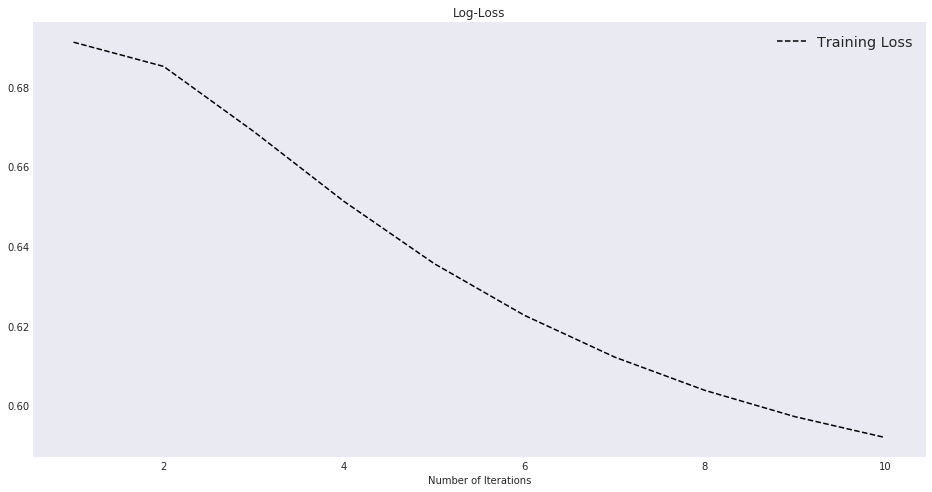

In [27]:
fig, ax = plt.subplots(1,1,figsize = (16,8))
x = list(range(1, len(losses)+1))
ax.plot(x, losses, 'k--', label='Training Loss')
ax.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Number of Iterations')
plt.title("Log-Loss")
plt.show()

## Evaluation of Holdout Development Set

In [28]:
def predictProb(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability AND return the gradient (?)
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of (label, predicted probability)
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    return (label, prob)

In [29]:
def testLoss(pair):
    """parallelize log loss
        input: (label, prob)
    """
    y = pair[0]
    
    eps = 1.0e-16
    if pair[1] == 0:
        y_hat = eps
    elif pair[1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In [30]:
k_br = sc.broadcast(k)

parsedTestDF = smallTestRDD.map(parseCV).toDF()
vectorizedTestDF = cvModel.transform(parsedTestDF)
testLoss = vectorizedTestDF.select(['label', 'features']).rdd \
                                    .map(lambda x: predictProb(x, k_br, b_br, w_br, V_br)) \
                                    .map(testLoss).mean()

print("Log-loss on the hold-out development set is:", testLoss)

Log-loss on the hold-out development set is: 0.5588072612641066


## Score Unlabeled Test Data

In [31]:
unlabeledRDD = sc.textFile('data/test.txt')
scoreTest = 0.001
smallUnlabeledRDD = unlabeledRDD.sample(False, scoreTest)

In [32]:
parsedUnlabeledDF = smallUnlabeledRDD.map(lambda x: "0\t"+x).map(parseCV).toDF()
vectorUnlabeledDF = cvModel.transform(parsedUnlabeledDF)
vectorUnlabeledDF.show(truncate=True)

+-----+--------------------+--------------------+
|label|                 raw|            features|
+-----+--------------------+--------------------+
|    0|[n0_<10, n1_<100,...|(25739,[0,1,4,5,6...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_0, n1_0, n2_<...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[3,5,6,8,1...|
|    0|[n0_0, n1_<100, n...|(25739,[0,1,2,3,4...|
|    0|[n0_<10, n1_0, n2...|(25739,[0,1,3,4,8...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,3,5,6...|
|    0|[n0_0, n1_<100, n...|(25739,[0,2,4,5,1...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,2,3,4,5...|
|    0|[n0_NA, n1_>100, ...|(25739,[1,2,3,6,1...|
|    0|[n0_0, n1_0, n2_>...|(25739,[0,1,4,6,9...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    0|[n0_NA, n1_<100, ...|(25739,[1,2,5,6,7...|
|    0|[n0_NA, n1_0, n2_...|(25739,[1,2,3,7,9...|
|    0|[n0_NA, n1_<100, ...|(25739,[0,1,2,3,4...|
|    0|[n0_<10, n1_<100,...|(25739,[0,1,2,3,4...|
|    0|[n0_<25, n1_<100,...|(25739,[0,1,3,4,5...|


In [33]:
unlabeledPred = vectorUnlabeledDF.select(['raw','features']).rdd.map(lambda x: predictProb(x, k_br, b_br, w_br, V_br))

In [35]:
unlabeledPred.take(1)

[(['n0_<10',
   'n1_<100',
   'n2_NA',
   'n3_0',
   'n4_<10k',
   'n5_0',
   'n6_<10',
   'n7_0',
   'n8_0',
   'n9_1',
   'n10_<3',
   'n11_<3',
   'n12_0',
   'c0_68fd1e64',
   'c1_942f9a8d',
   'c2_c451a590',
   'c3_671f7598',
   'c4_25c83c98',
   'c5_fbad5c96',
   'c6_3f4ec687',
   'c7_5b392875',
   'c8_a73ee510',
   'c9_e113fc4b',
   'c10_c4adf918',
   'c11_2133afad',
   'c12_85dbe138',
   'c13_1adce6ef',
   'c14_ae97ecc3',
   'c15_b47bfaf2',
   'c16_3486227d',
   'c17_1f868fdd',
   'c18_04de9d96',
   'c19_b1252a9d',
   'c20_3c17ccda',
   'c21_NA',
   'c22_32c7478e',
   'c23_e5fe7725',
   'c24_001f3601',
   'c25_69a16fdc'],
  0.3302264369277568)]

## Full Model Training on GCP Cluster

## 5. Key Concepts of Machine Learning at Scale  

*Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.*